In [355]:
import os
import pyspark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

## Init PySpark

In [2]:
SUBMIT_ARGS = "--packages com.databricks:spark-csv_2.11:1.2.0 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

In [3]:
# Make sure the driver and workers all use Python2
os.environ['PYSPARK_PYTHON'] = '/opt/conda/envs/python2/bin/python'

# Init Spark Context
sc = pyspark.SparkContext('local[*]')

# Init Spark SQL Context
sql_ctx = SQLContext(sc)

# do something to prove it works
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

[799, 899, 982, 28, 442]

## Load CSV Data

In [368]:
flights_1987_df = sql_ctx.read.format('com.databricks.spark.csv').options(header='true').load('../data/1987.csv')

In [369]:
flights_1987_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

In [370]:
def convertColumn(df, name, newType) :
    df_1 = df.withColumnRenamed(name, "swap")
    df_1 = df_1.withColumn(name, df_1["swap"].cast(newType)).drop("swap")
    return df_1

In [371]:
flights_1987_df = convertColumn(flights_1987_df, "DayOfWeek", "int")
flights_1987_df = convertColumn(flights_1987_df, "ArrDelay", "int")
flights_1987_df = convertColumn(flights_1987_df, "DepDelay", "int")

In [372]:
flights_1987_df.registerTempTable("flight")

In [373]:
# TODO save the DataFrame in parquet file or in cassandra...

## When is the best time of day of time of year to fly to minimise delays?

In [374]:
# SQL Request method
#sql_ctx.sql("""SELECT DayOfWeek as weekday, avg(ArrDelay) as avg_delay 
#                                FROM flight
#                                GROUP BY DayOfWeek
#                                ORDER BY avg_delay DESC""").show()

In [375]:
# DataFrame syntax
df_minimise_delays_weekday = (flights_1987_df
                              .select('DayOfWeek', 'ArrDelay')
                              .groupBy('DayOfWeek')
                              .agg(F.avg('ArrDelay').alias('AVG_DELAY_ARR')))

In [376]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def convert_day_of_week(val):
    week   = ['Monday', 
              'Tuesday', 
              'Wednesday', 
              'Thursday',  
              'Friday', 
              'Saturday',
              'Sunday']
    
    return week[int(val)-1]


In [377]:
# NOTE: it seems that calls to udf() must be after SparkContext() is called
udf_convert_day_of_week = udf(convert_day_of_week, StringType())

In [378]:
df_minimise_delays_weekday = df_minimise_delays_weekday.withColumn("DAY_OF_WEEK", udf_convert_day_of_week(df_minimise_delays_weekday['DayOfWeek']))

In [379]:
df_minimise_delays_weekday[["DAY_OF_WEEK", "AVG_DELAY_ARR"]].show()

+-----------+------------------+
|DAY_OF_WEEK|     AVG_DELAY_ARR|
+-----------+------------------+
|     Monday| 9.423212438582881|
|    Tuesday|11.504344921586691|
|  Wednesday|11.233518950001068|
|   Thursday| 9.764202840820278|
|     Friday| 8.791372742470333|
|   Saturday| 5.928266598260302|
|     Sunday| 9.154889545518502|
+-----------+------------------+



<function matplotlib.pyplot.legend>

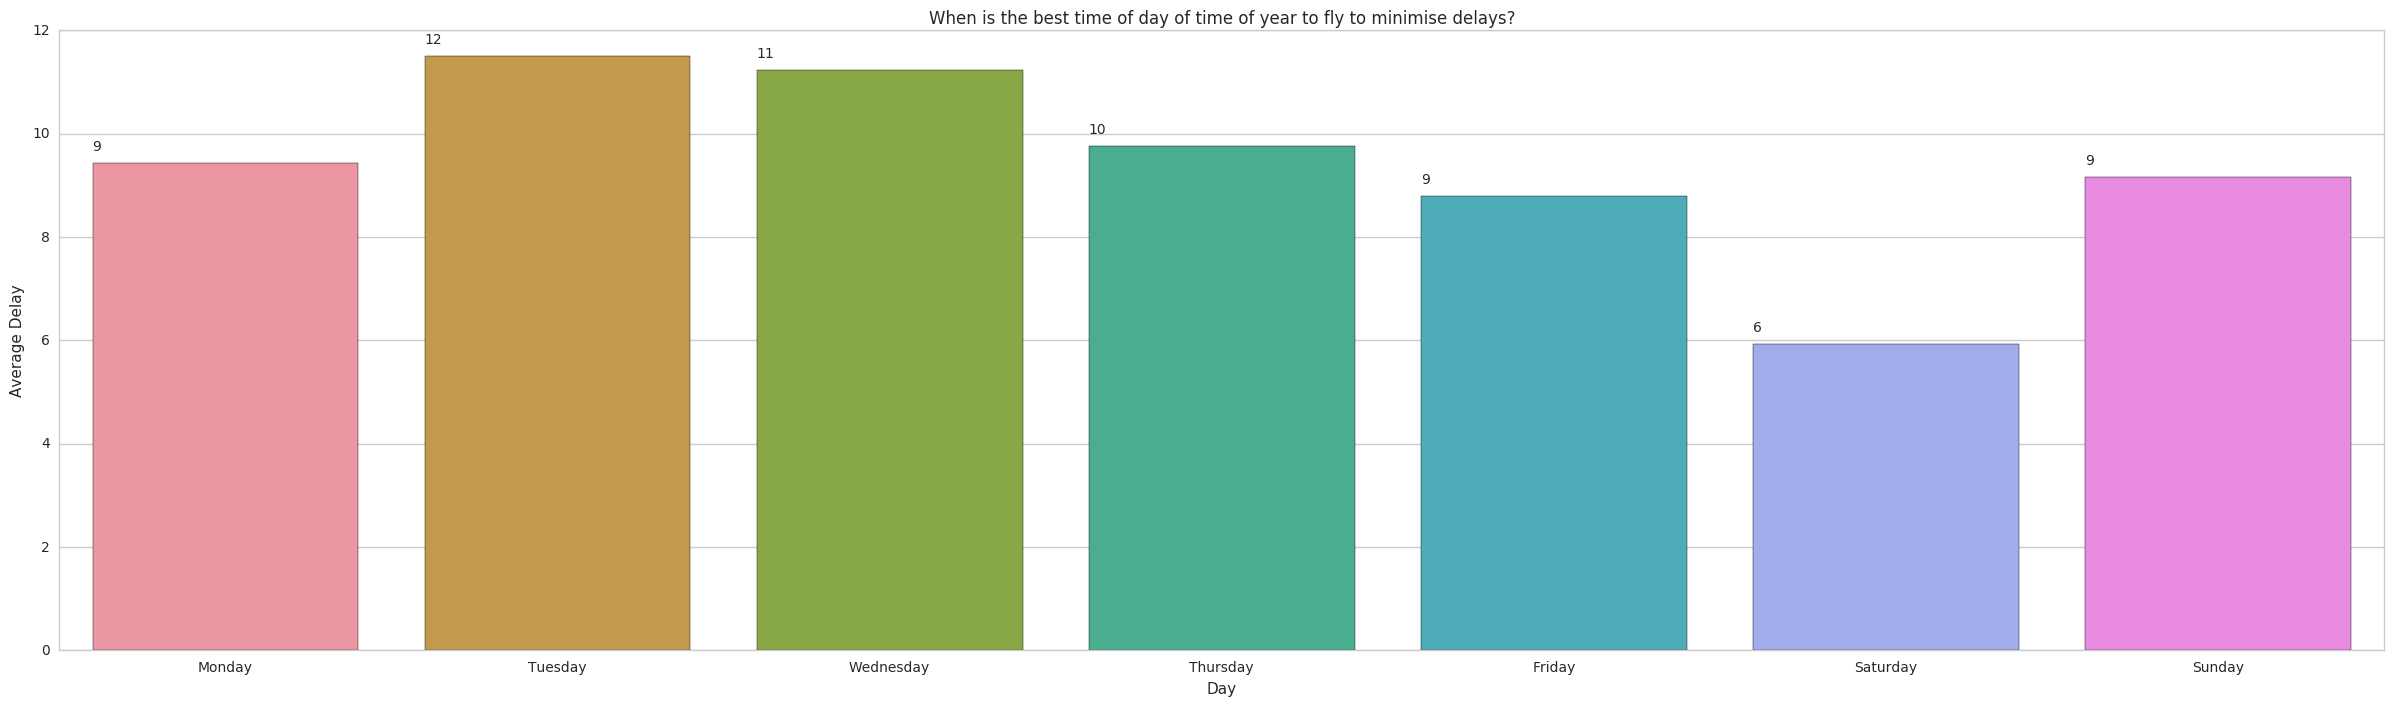

In [380]:
sns.set_style('whitegrid')
df_minimise_delays_weekday_pd = df_minimise_delays_weekday.toPandas()

plt.figure(figsize=(30,8))
ax = sns.barplot(x='DAY_OF_WEEK', y='AVG_DELAY_ARR', data=df_minimise_delays_weekday_pd)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+ 0.25, '%1.00f'%p.get_height())
plt.title('When is the best time of day of time of year to fly to minimise delays?')
plt.xlabel('Day')
plt.ylabel('Average Delay')
plt.legend

In [390]:
df_minimise_delays_weekday_month = (flights_1987_df
                               .select('Month', 'DayOfWeek', 'ArrDelay')
                               .groupBy('DayOfWeek').pivot('Month').avg('ArrDelay'))
# Create Column DAY_OF_WEEK : convert int => string value
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumn("DAY_OF_WEEK", udf_convert_day_of_week(df_minimise_delays_weekday['DayOfWeek']))
# Drop DayOfWeek (int value)
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.drop("DayOfWeek")
# Update column name : convert int month to str month
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("10", "October")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("11", "November")
df_minimise_delays_weekday_month = df_minimise_delays_weekday_month.withColumnRenamed("12", "December")
df_minimise_delays_weekday_month.show()

+-----------------+------------------+------------------+-----------+
|          October|          November|          December|DAY_OF_WEEK|
+-----------------+------------------+------------------+-----------+
|4.894294756650415| 8.835708937633454|15.003070549973655|     Monday|
|6.292136746310372|10.482892825019027|16.782797378813523|    Tuesday|
|6.646462578069008| 9.897410427993865|16.090022210351712|  Wednesday|
|7.372927988667784| 9.368406598436442| 12.56968058618482|   Thursday|
|7.294044597287044| 6.911955257766211|12.638297872340425|     Friday|
|3.709878766054495| 3.270287332134522|11.380422797612258|   Saturday|
| 5.43834829443447| 9.663520674015471| 12.35584815956617|     Sunday|
+-----------------+------------------+------------------+-----------+



In [395]:
# Convert to Pandas
pd_minimise_delays_weekday_month = df_minimise_delays_weekday_month.toPandas()

# Add Month column name to index columns
pd_minimise_delays_weekday_month.columns.names = ['Month']

# Update index values by DAY_OF_WEEK values & drop DAY_OF_WEEK columns
pd_minimise_delays_weekday_month = pd_minimise_delays_weekday_month.rename(index=pd_minimise_delays_weekday_month.DAY_OF_WEEK).drop('DAY_OF_WEEK', axis=1)
pd_minimise_delays_weekday_month

Month,October,November,December
Monday,4.894295,8.835709,15.003071
Tuesday,6.292137,10.482893,16.782797
Wednesday,6.646463,9.897410,16.090022
Thursday,7.372928,9.368407,12.569681
Friday,7.294045,6.911955,12.638298
Saturday,3.709879,3.270287,11.380423
Sunday,5.438348,9.663521,12.355848


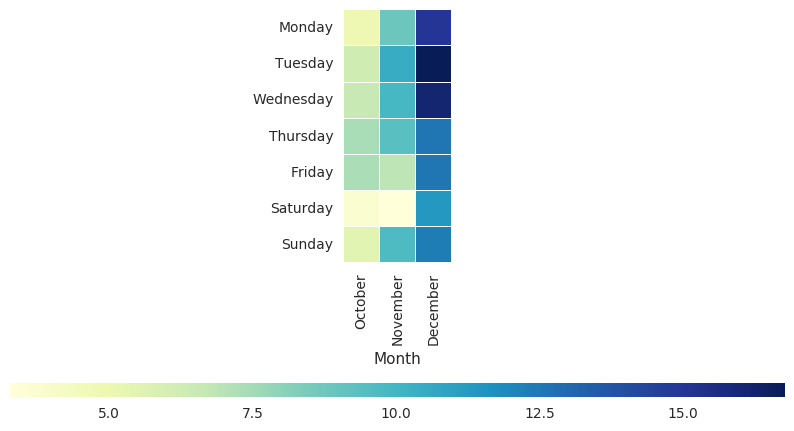

In [399]:
# Draw a heatmap 
grid_kws = {"height_ratios": (.9, .05), "hspace": 0.9}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(10, 5),gridspec_kw=grid_kws)
sns.heatmap(pd_minimise_delays_weekday_month, ax=ax, linewidths=0.01, cmap="YlGnBu", square=True, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"})

## Load Airports Data

In [400]:
airports_df = sql_ctx.read.format('com.databricks.spark.csv').options(header='true').load('../data/airports.csv')

In [401]:
airports_df.printSchema()

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



## When is the best airport to fly to minimise delays?

In [402]:
df_minimise_delays_airport_dest = (flights_1987_df
                              .select('Dest', 'ArrDelay')
                              .groupBy('Dest')
                              .agg(F.avg('ArrDelay').alias('AVG_DELAY_ARR'))
                              .sort(F.desc('AVG_DELAY_ARR')))

In [403]:
# merge with airport data

df_minimise_delays_airport_dest = (df_minimise_delays_airport_dest
                 .join(airports_df, df_minimise_delays_airport_dest.Dest == airports_df.iata, 'inner'))
df_minimise_delays_airport_dest.show(4)

+----+------------------+----+--------------------+-------+-----+-------+-----------+------------+
|Dest|     AVG_DELAY_ARR|iata|             airport|   city|state|country|        lat|        long|
+----+------------------+----+--------------------+-------+-----+-------+-----------+------------+
| IAH|11.824664156556501| IAH|George Bush Inter...|Houston|   TX|    USA|29.98047222|-95.33972222|
| GEG|12.228323699421965| GEG|        Spokane Intl|Spokane|   WA|    USA|47.61985556|-117.5338425|
| YUM|  5.77319587628866| YUM|Yuma MCAS-Yuma In...|   Yuma|   AZ|    USA|32.65658333|-114.6059722|
| TUS|12.350730688935283| TUS|Tucson International| Tucson|   AZ|    USA|32.11608333|-110.9410278|
+----+------------------+----+--------------------+-------+-----+-------+-----------+------------+
only showing top 4 rows

